In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import json

import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)


/usr/bin/python


In [2]:
ticker = params.ticker
base_csv = params.base_csv

# 1) Glob all ticker-specific JSONs
pattern = os.path.join(params.optuna_folder, f"{ticker}_*.json")
files   = glob.glob(pattern)

# 2) Pick the one with the largest value in its filename
#     filenames are like "AAPL_0.603650.json"
best_file = max(
    files,
    key=lambda fn: float(os.path.basename(fn)
                              .replace(f"{ticker}_", "")
                              .replace(".json", ""))
)

# 3) Load it
with open(best_file) as fp:
    best_record = json.load(fp)

best_value  = best_record["value"]
best_params = best_record["params"]

print(f"Using best Optuna trial {best_value:.6f}:")

# adjust the best_params dictionary with exactly the hyperparameters that the function run_trading_pipeline needs

minutes_total = (
    params.regular_start.hour * 60
  + params.regular_start.minute
)

look_back = best_params.pop("look_back")

regular_start_pred = dt.time(*divmod(minutes_total - look_back, 60))
regular_start_shifted_more = dt.time(*divmod(minutes_total - (look_back*2 + 30), 60)) # adding additional 30 minutes to calculate the features indicators afterwards

best_params["regular_start_shifted"] = regular_start_shifted_more 

best_params

Using best Optuna trial 0.379204:


{'min_prof_thr': 0.14936641099166223,
 'max_down_prop': 0.01052225424215529,
 'gain_tightening_factor': 0.5299213071977746,
 'merging_retracement_thr': 0.07830451763395935,
 'merging_time_gap_thr': 0.30206728730433513,
 'pre_entry_decay': 0.1392263403515707,
 'short_penal_decay': 2.6893668778672706,
 'trailing_stop_pct': 0.032860909981238286,
 'buy_threshold': 0.6971635060500512,
 'top_percentile': 3.916913617121738,
 'smoothing_window': 3,
 'regular_start_shifted': datetime.time(12, 0)}

[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


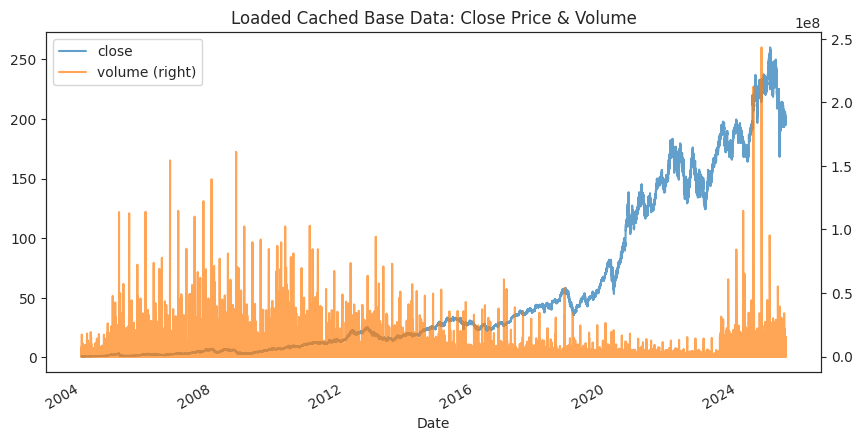

open        high         low       close  \
2004-01-02 09:00:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:01:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:02:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:03:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 09:04:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume        ask         bid  
2004-01-02 09:00:00     28000.0    0.76505    0.763521  
2004-01-02 09:01:00     28000.0    0.76505    0.763521  
2004-01-02 09:02:00     28000.0    0.76505    0.763521  
2004-01-02 09:03:00     28000.0    0.76505    0.763521  
2004-01-02 09:04:00     28000.0    0.76505    0.763521  
...                         ...        ...         ...  
2025-06-18 20:56:00    385695.0  197.01180  196.618200  
2025-06-18 20:57:00    460630.0  196.87170  196.478300  
2025-06-18 20:58:00    525245.0  196.86670  196.473300  
2025-06-18 20:59:00   2075503.0  196.43620  196.043800  
2025-06-18 21:00:00  15600625.0  196.73650  196.343500  

[3893400 rows x 7 columns]

In [3]:

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_pct        = params.bidasktoclose_pct
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = best_params["regular_start_shifted"],
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [4]:
def process_single_day(day_str: str, hyperparams: dict, regular_start_pred):
    """
    Process and plot a single trading session using a given set of hyperparameters.

    Returns:
      Tuple[pd.DataFrame, Dict] | None
        If a valid backtest runs, returns (df_day, perf_day).
        If no data or no trades, returns None.
    """
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    # Extract that day’s full-minute bars from the master df
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return

    print("\n Running trading pipeline on selected date …")
    # Call run_trading_pipeline with your per-day slice + EXACTLY the same hyperparams
    result = trades.run_trading_pipeline(
                                        df                       = day_df,
                                        col_signal               = 'signal',
                                        col_action               = 'signal_action',
                                        day_to_check             = day_str,
                                        **hyperparams            # unpack your tuned parameters here
    )
    if result is None:
        print(" no trades found; skipping.")
        return

    # Unpack pipeline output: (df_signals, trades_list, performance_stats)
    df_day, trades_day, perf_day = result

    # Plot the equity & trade markers
    plots.plot_trades(
                    df                 = df_day,
                    col_signal1        = 'signal',
                    col_signal2        = False,
                    col_action         = 'signal_action',
                    trades             = trades_day,
                    buy_threshold      = hyperparams['buy_threshold'],
                    performance_stats  = perf_day,
                    regular_start_pred = regular_start_pred
    )

    # Print the per-day summary
    print(f"\n* Performance for {day_dt.date()} *")
    for k, v in perf_day.items():
        print(f"  {k}: {v}")

    return df_day, perf_day


In [5]:
def saveDF_checkDAY(df: pd.DataFrame, hyperparams: dict):
    """
    Backtest in two modes and optionally save a full‐run CSV of signals,
    using the supplied hyperparameters.

    Modes:
      • Month mode (params.date_to_check = 'YYYY-MM'):
          – process each trading day via process_single_day(..., hyperparams)
          – plot monthly aggregate performance
          – return the month’s concatenated DataFrame (empty if none)

      • Full‐run mode (params.createCSVsign == True):
          – run the identical pipeline used by Optuna over all days
            with **hyperparams
          – compute & print the full‐period summary
          – plot full‐period performance
          – isolate & compute the test‐period summary
          – plot test‐period performance
          – save the dataframe with the calculated signal
          – return the full‐run DataFrame
    """
    keep_cols = [
        "open","high","low","close",
        "volume","bid","ask",
        "StrategyEarning","EarningDiff",
        "signal","signal_action"
    ]

    # ── Month mode ────────────────────────────────────────────────────
    print(f"\nMonth mode: processing {params.date_to_check}")
    month_days = (
                df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
                  .index.normalize()
                  .unique()
    )

    month_frames, month_stats = [], []
    for day in sorted(month_days):
        # Pass hyperparams into process_single_day
        res = process_single_day(day_str = str(day.date()), 
                                 hyperparams = hyperparams, 
                                 regular_start_pred = regular_start_pred)
        if res is None:
            continue
        df_day, stats = res
        month_frames.append(df_day)
        month_stats.append(stats)

    if not month_frames:
        print("No valid days in this month.")
        return pd.DataFrame(columns=keep_cols)

    df_month = pd.concat(month_frames).sort_index()
    plots.aggregate_performance(month_stats, df_month)

    # If we aren’t saving a full-run CSV, bail out
    if not params.createCSVsign:
        return df_month

    # ── Full‐run mode ────────────────────────────────────────────────
    print("\nFull‐run mode")
    print("• Running trading pipeline on full dataset …")
    # Unpack hyperparams into run_trading_pipeline exactly as in Optuna
    full_sim_results = trades.run_trading_pipeline(
                                                    df            = df,
                                                    col_signal    = 'signal',
                                                    col_action    = 'signal_action',
                                                    **hyperparams
    )

    # 1) Build combined DF & perf list (zeros on no‐trade days)
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    df_all       = pd.concat(daily_frames).sort_index()
    perf_all     = [res[2] for res in full_sim_results.values()]

    # 2) Print & plot full‐period performance using df_all
    print("\nFull‐period performance:")
    plots.aggregate_performance(perf_all, df_all)

    # 3) Test‐period slice & plot
    days_all  = df_all.index.normalize().unique()
    cutoff    = int(len(days_all) * (params.train_prop + params.val_prop))
    test_days = days_all[cutoff:]
    df_test   = df_all[df_all.index.normalize().isin(test_days)]
    perf_test = [
        stats
        for day, (_, _, stats) in full_sim_results.items()
        if pd.Timestamp(day).normalize() in test_days
    ]

    print("\nTest‐period performance:")
    plots.aggregate_performance(perf_test, df_test)

    # Save the full-run signals CSV
    print("\n• Saving signals CSV …")
    df_all.to_csv(params.sign_csv)
    print(f"Saved to {params.sign_csv}")

    return df_all



Month mode: processing 2025-05

=== Processing trading day 2025-05-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


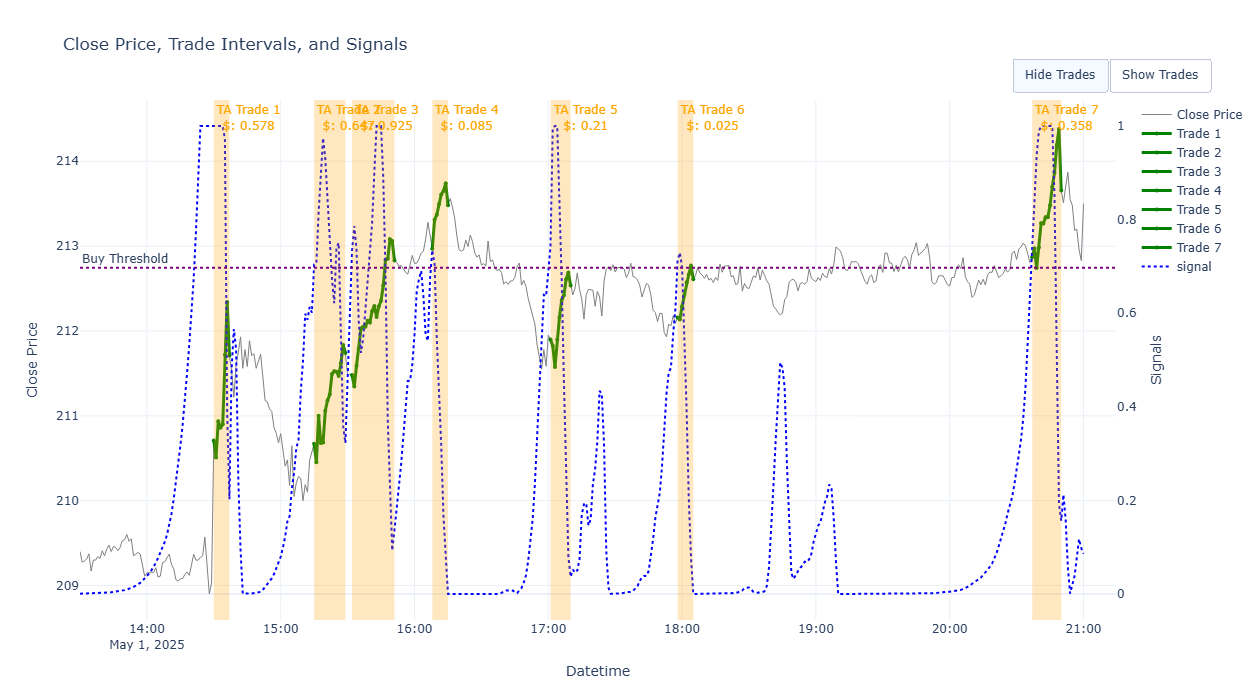


* Performance for 2025-05-01 *
  Buy & Hold Return ($): 2.366
  Strategy Return ($): 2.831
  Trades Returns ($): [0.578, 0.647, 0.925, 0.085, 0.21, 0.025, 0.358]

=== Processing trading day 2025-05-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


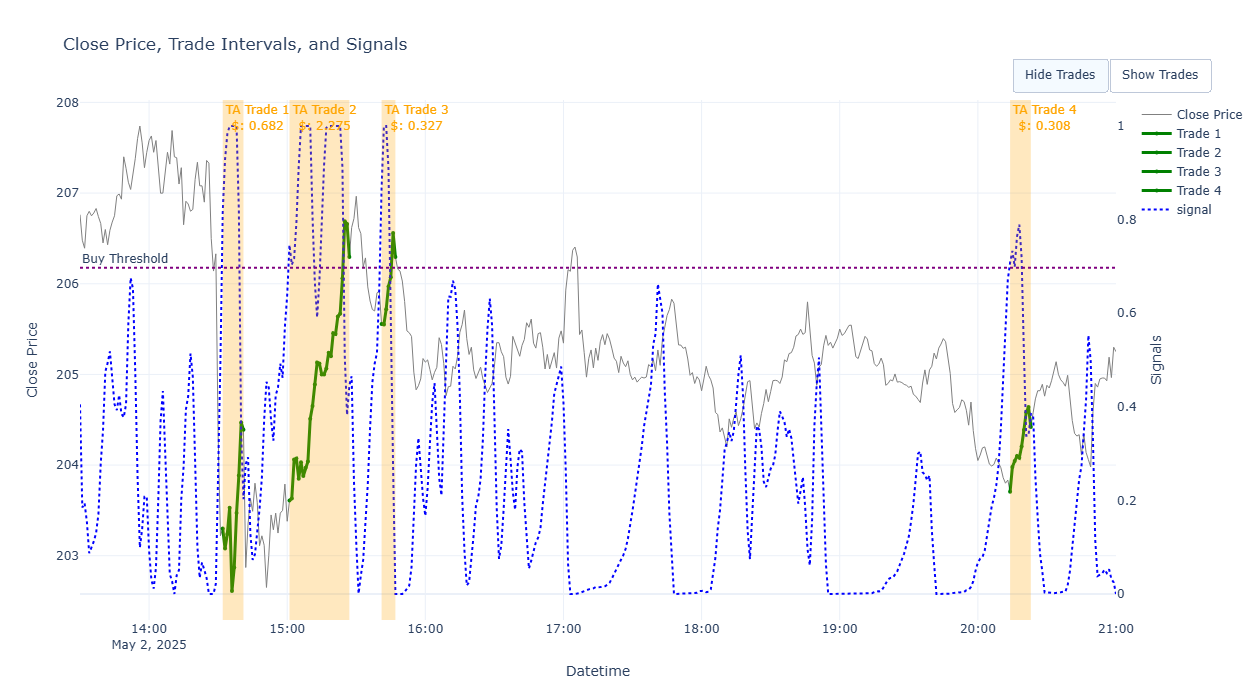


* Performance for 2025-05-02 *
  Buy & Hold Return ($): 0.506
  Strategy Return ($): 3.592
  Trades Returns ($): [0.682, 2.275, 0.327, 0.308]

=== Processing trading day 2025-05-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


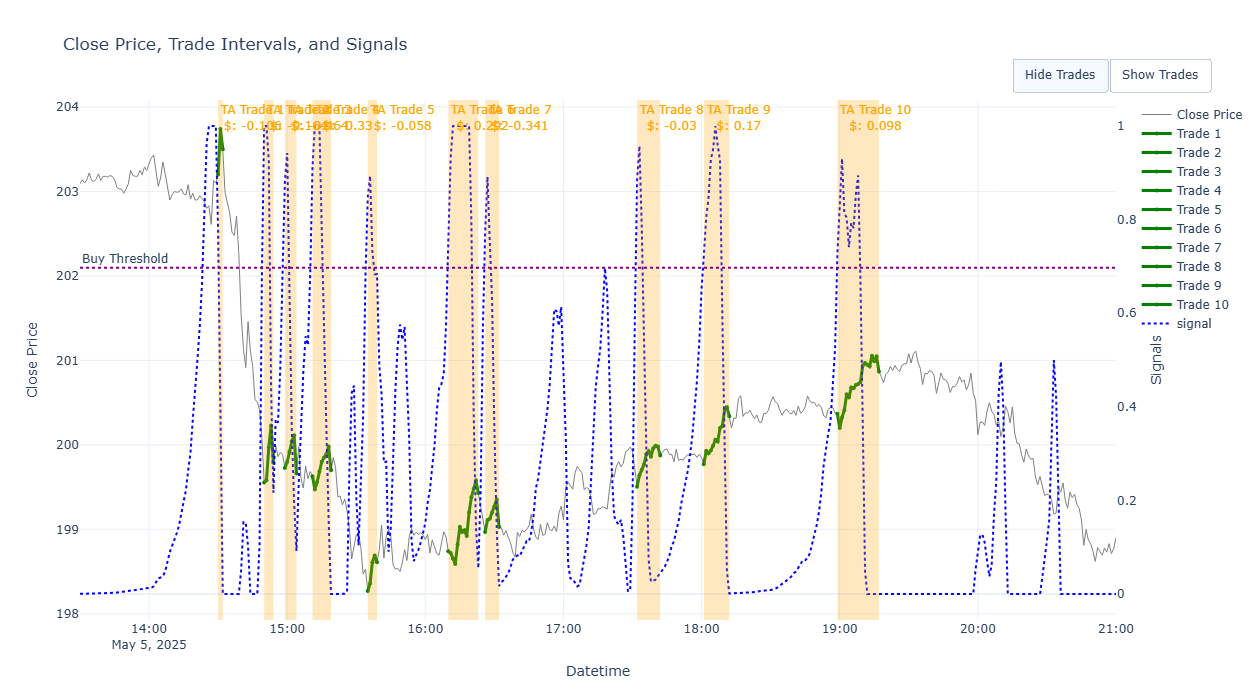


* Performance for 2025-05-05 *
  Buy & Hold Return ($): -4.702
  Strategy Return ($): -0.932
  Trades Returns ($): [-0.106, -0.164, -0.464, -0.33, -0.058, 0.292, -0.341, -0.03, 0.17, 0.098]

=== Processing trading day 2025-05-06 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


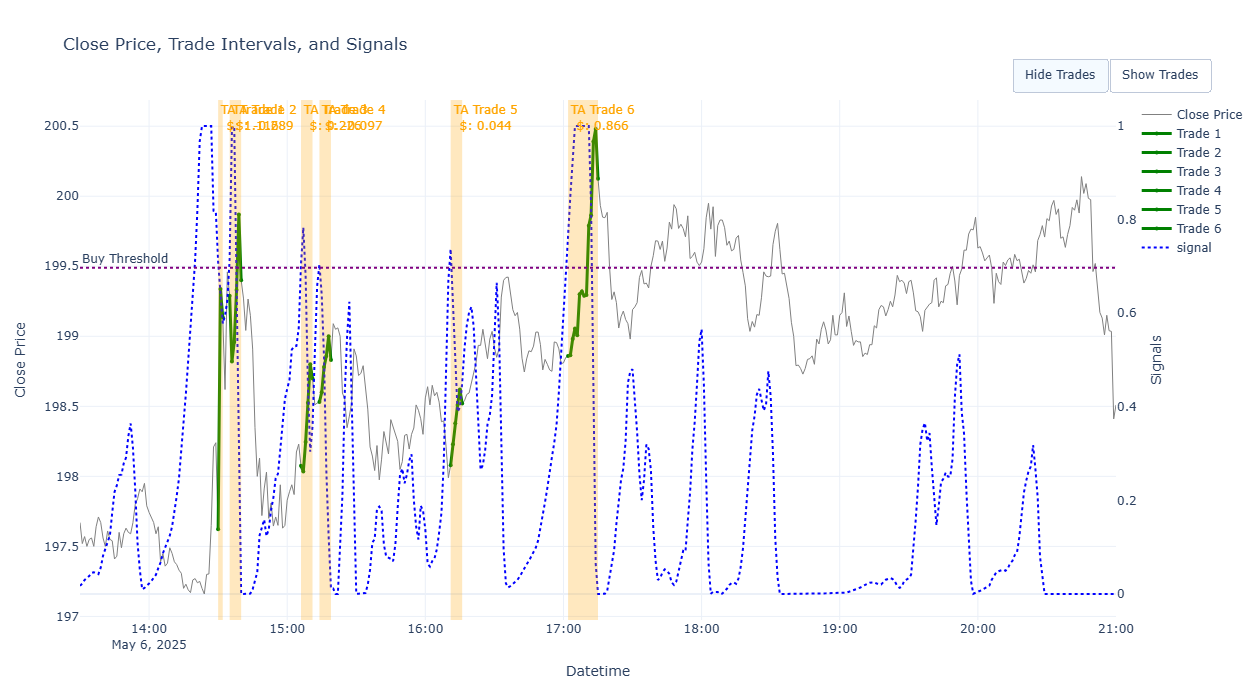


* Performance for 2025-05-06 *
  Buy & Hold Return ($): 0.492
  Strategy Return ($): 1.866
  Trades Returns ($): [1.116, -0.289, 0.226, -0.097, 0.044, 0.866]

=== Processing trading day 2025-05-07 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


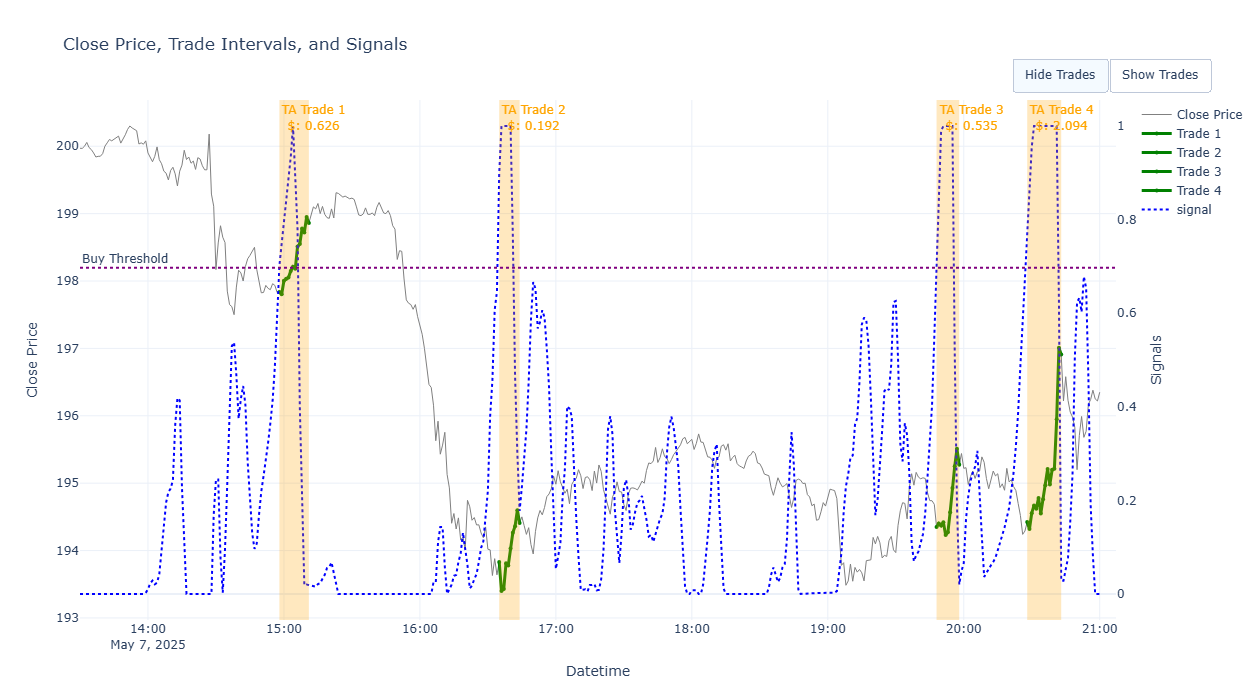


* Performance for 2025-05-07 *
  Buy & Hold Return ($): -2.215
  Strategy Return ($): 3.446
  Trades Returns ($): [0.626, 0.192, 0.535, 2.094]

=== Processing trading day 2025-05-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


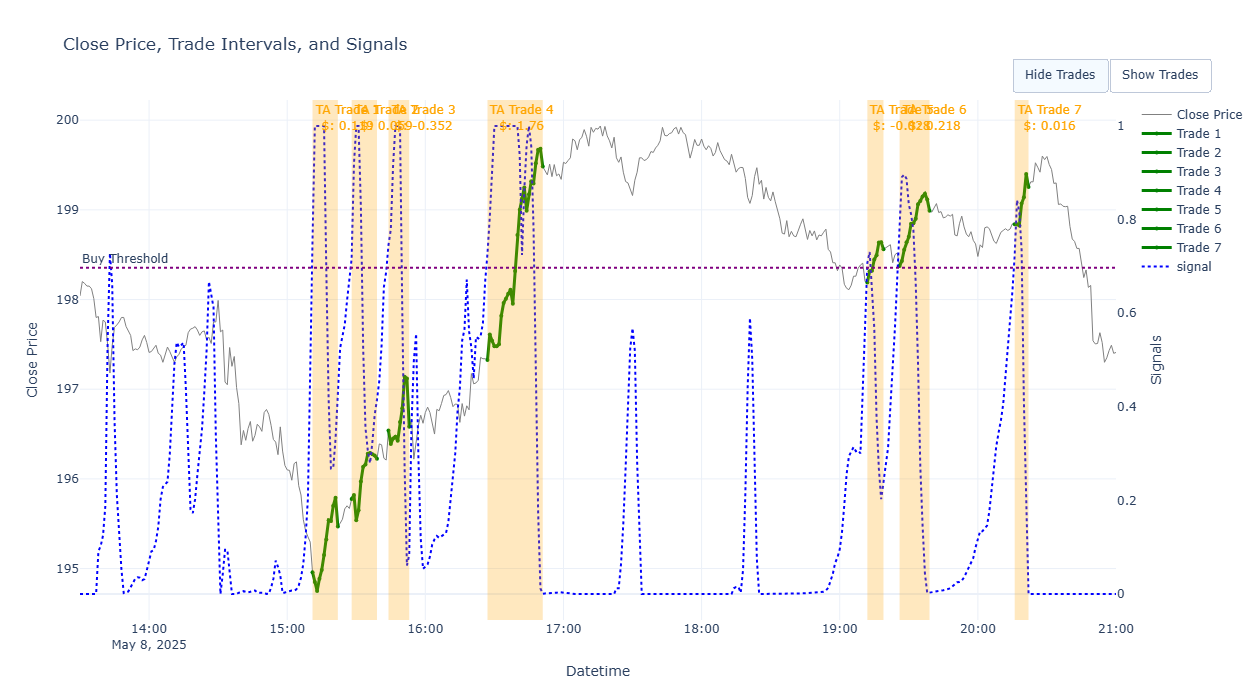


* Performance for 2025-05-08 *
  Buy & Hold Return ($): -0.975
  Strategy Return ($): 1.792
  Trades Returns ($): [0.119, 0.059, -0.352, 1.76, -0.028, 0.218, 0.016]

=== Processing trading day 2025-05-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


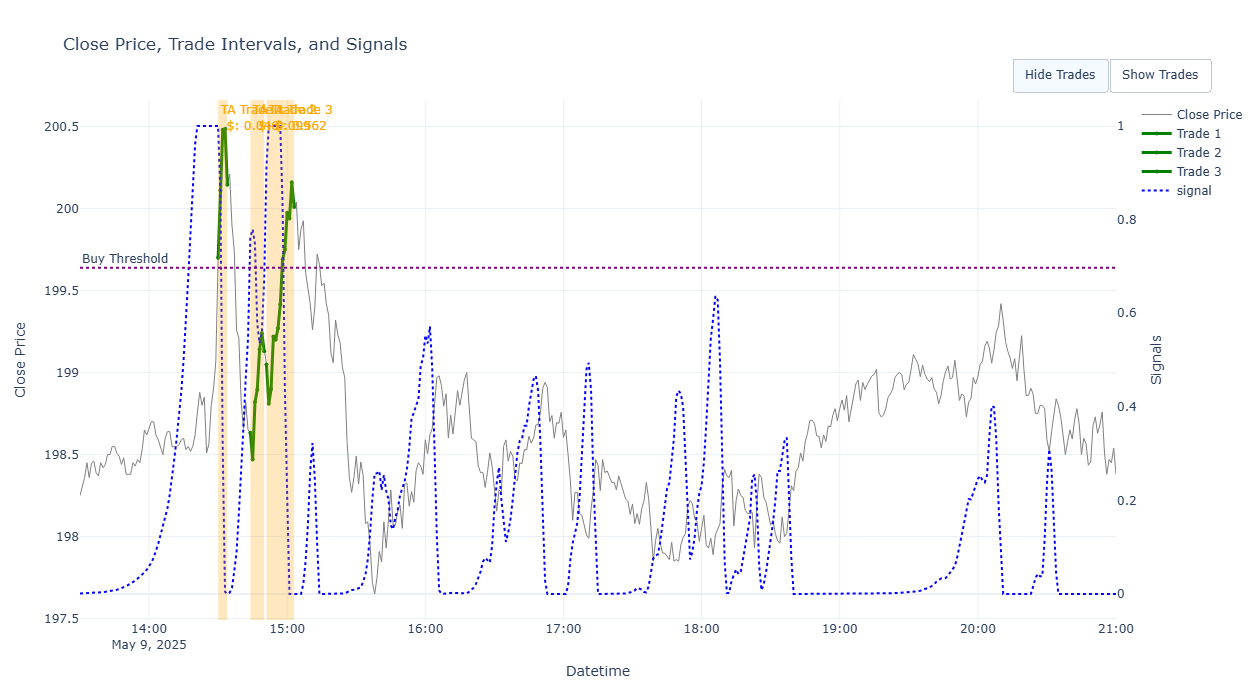


* Performance for 2025-05-09 *
  Buy & Hold Return ($): -1.718
  Strategy Return ($): 0.705
  Trades Returns ($): [0.046, 0.099, 0.562]

=== Processing trading day 2025-05-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


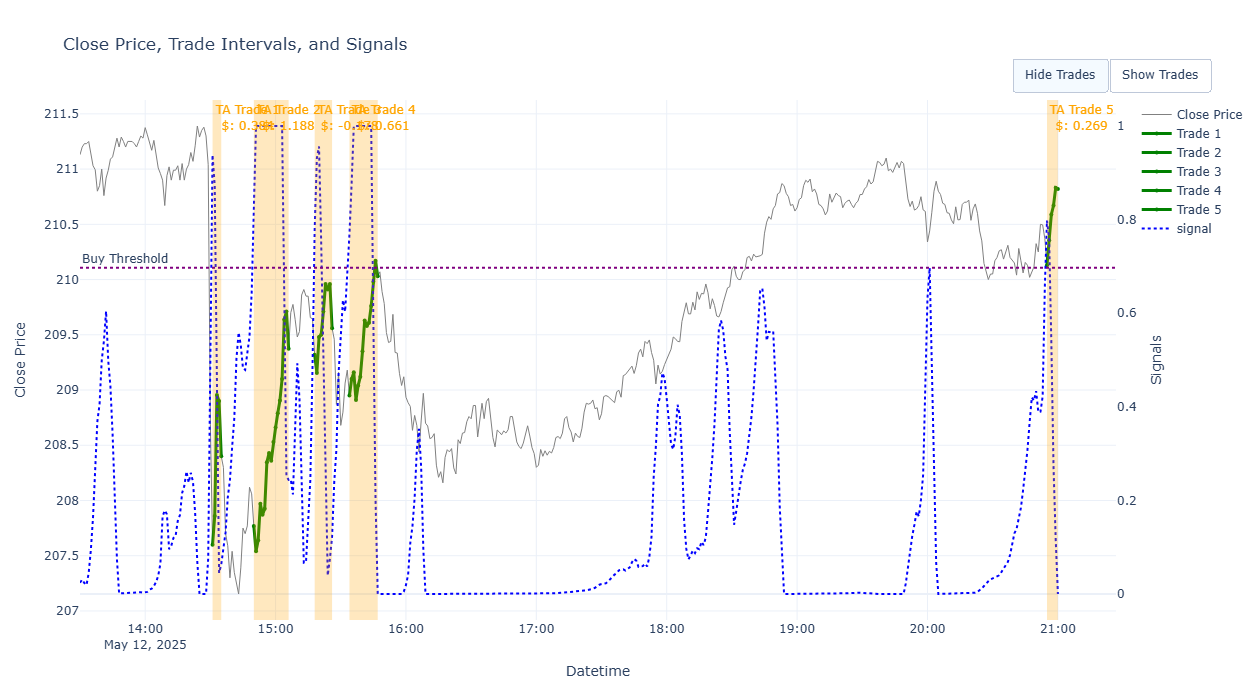


* Performance for 2025-05-12 *
  Buy & Hold Return ($): 1.71
  Strategy Return ($): 2.323
  Trades Returns ($): [0.384, 1.188, -0.178, 0.661, 0.269]

=== Processing trading day 2025-05-13 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


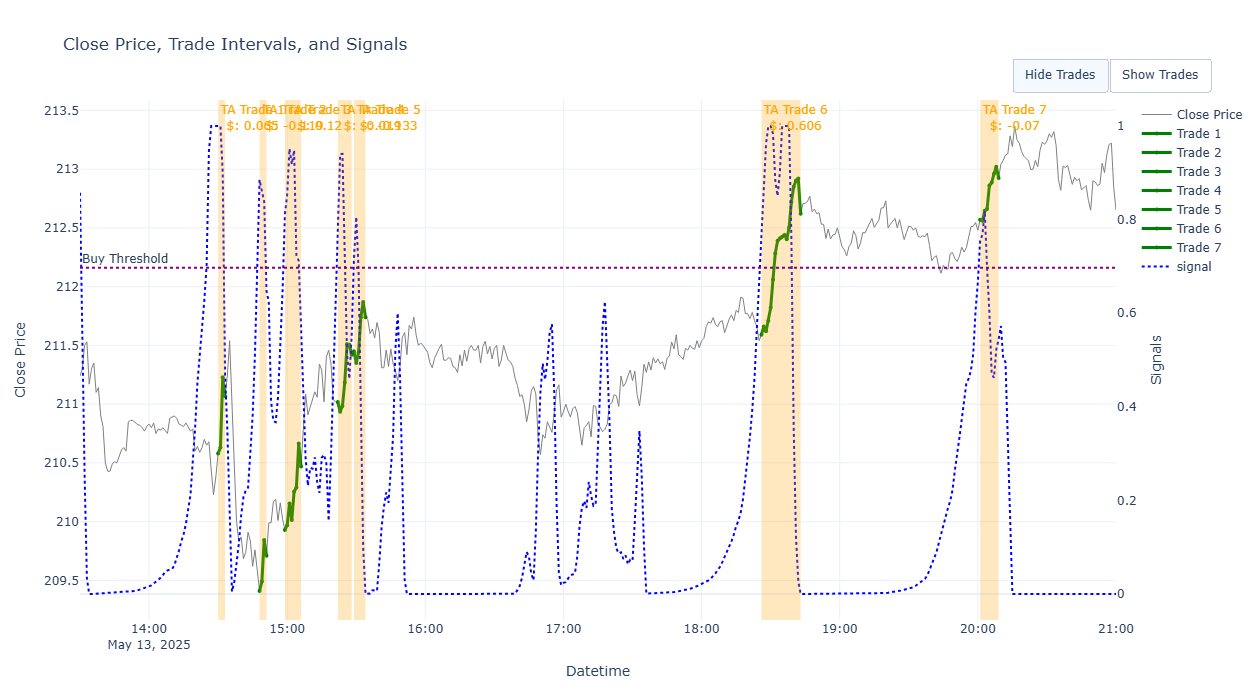


* Performance for 2025-05-13 *
  Buy & Hold Return ($): 1.647
  Strategy Return ($): 0.448
  Trades Returns ($): [0.065, -0.119, 0.12, -0.019, -0.133, 0.606, -0.07]

=== Processing trading day 2025-05-14 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


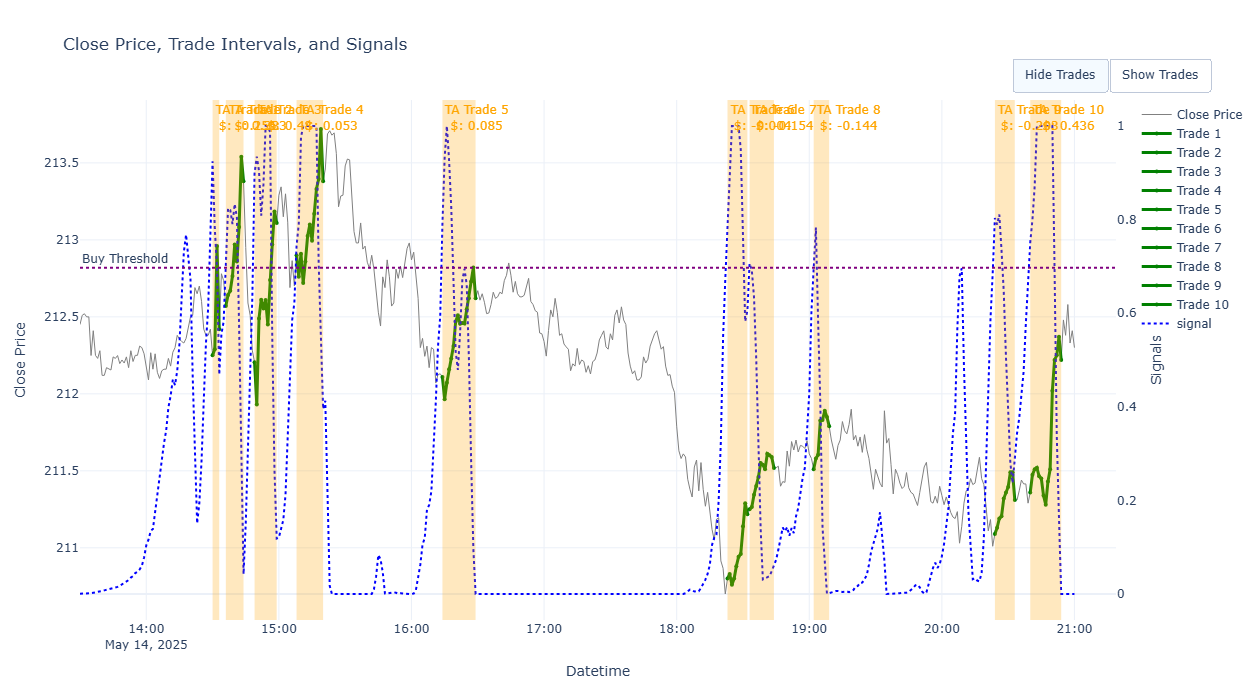


* Performance for 2025-05-14 *
  Buy & Hold Return ($): -0.374
  Strategy Return ($): 0.681
  Trades Returns ($): [-0.255, 0.383, 0.48, 0.053, 0.085, -0.004, -0.154, -0.144, -0.203, 0.436]

=== Processing trading day 2025-05-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


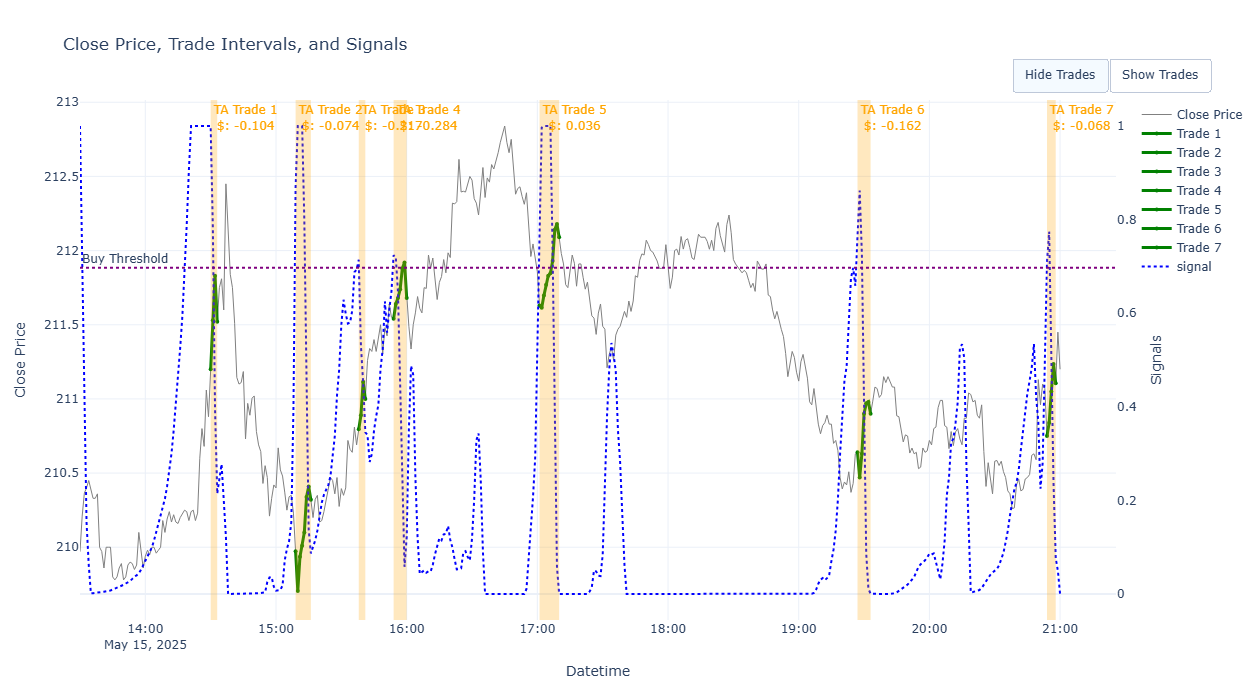


* Performance for 2025-05-15 *
  Buy & Hold Return ($): -0.422
  Strategy Return ($): -0.868
  Trades Returns ($): [-0.104, -0.074, -0.217, -0.284, 0.036, -0.162, -0.068]

=== Processing trading day 2025-05-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


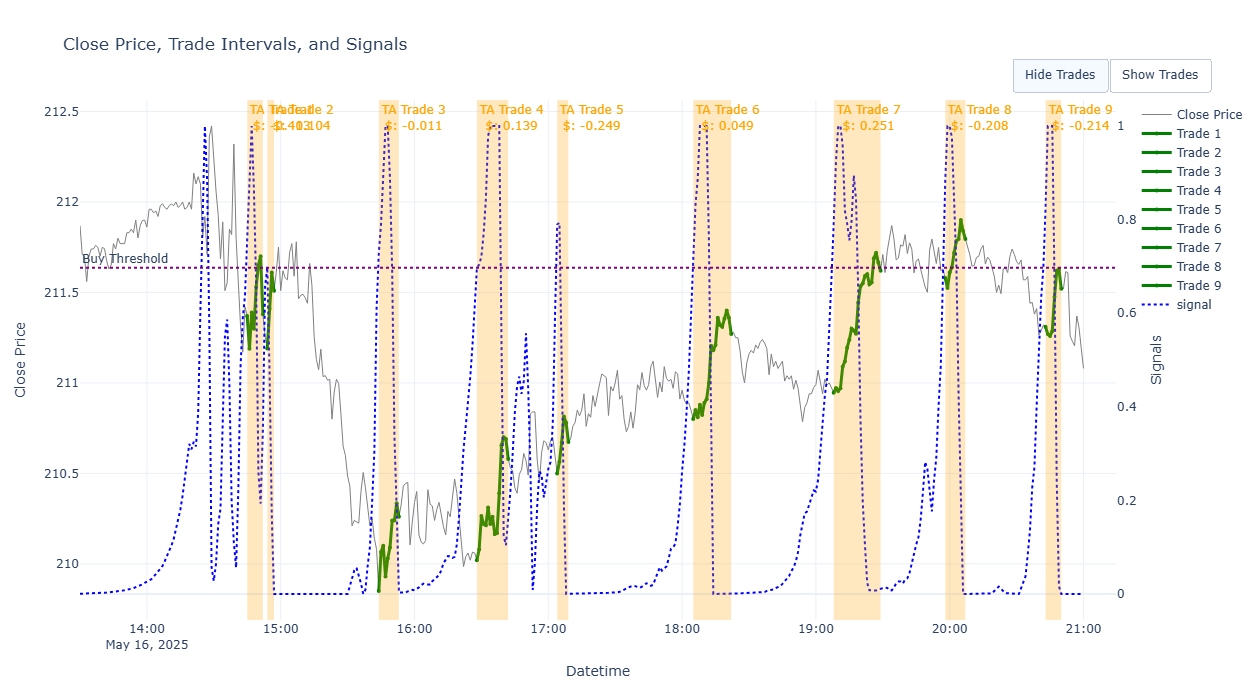


* Performance for 2025-05-16 *
  Buy & Hold Return ($): -1.573
  Strategy Return ($): -0.755
  Trades Returns ($): [-0.413, -0.104, -0.011, 0.139, -0.249, 0.049, 0.251, -0.208, -0.214]

=== Processing trading day 2025-05-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


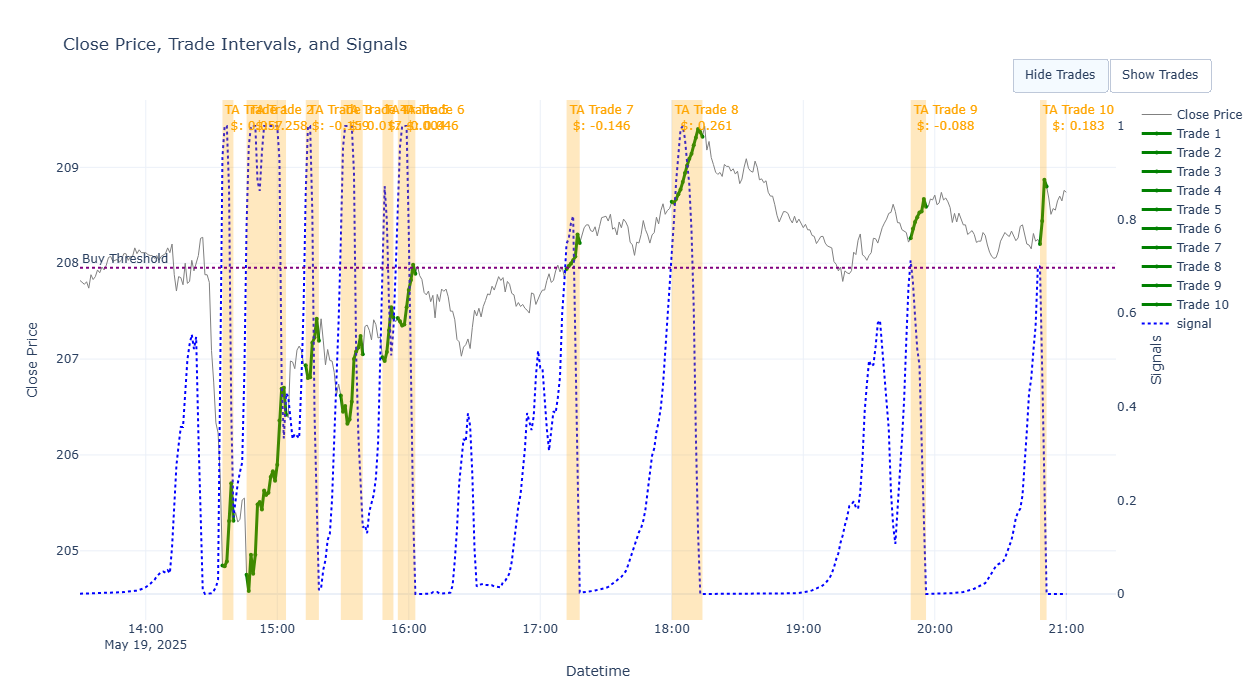


* Performance for 2025-05-19 *
  Buy & Hold Return ($): 1.234
  Strategy Return ($): 1.426
  Trades Returns ($): [0.057, 1.258, -0.159, 0.017, -0.004, 0.046, -0.146, 0.261, -0.088, 0.183]

=== Processing trading day 2025-05-20 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


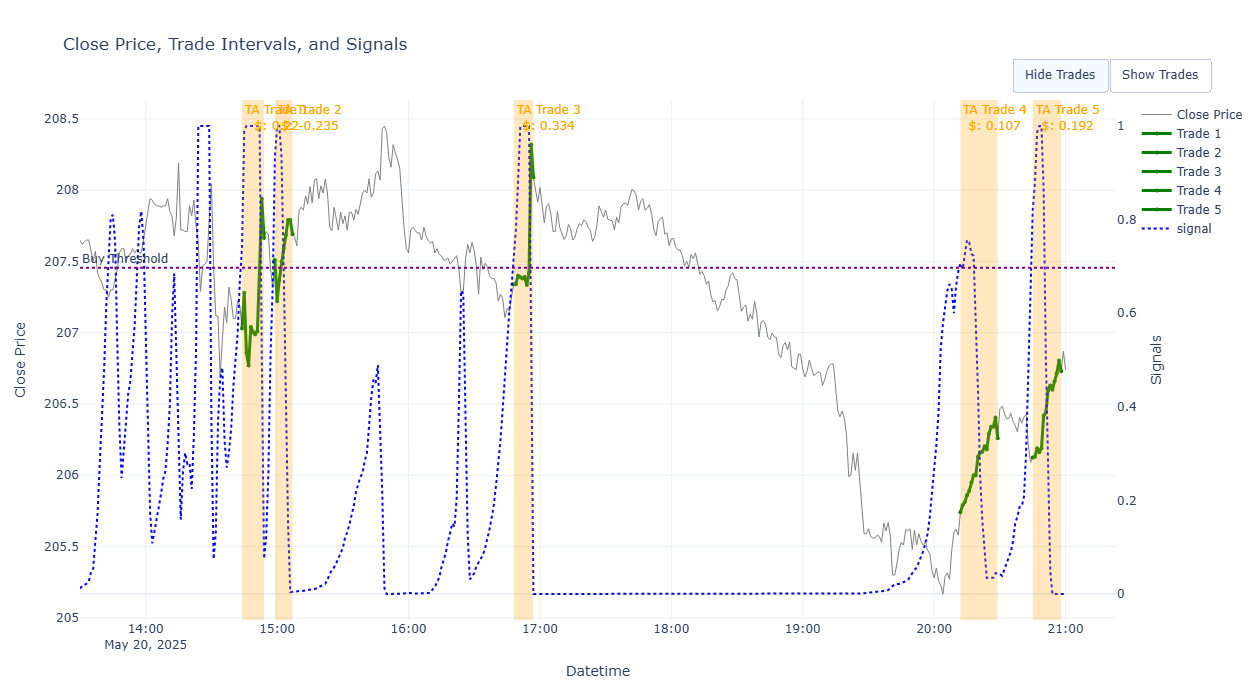


* Performance for 2025-05-20 *
  Buy & Hold Return ($): -1.72
  Strategy Return ($): 0.62
  Trades Returns ($): [0.22, -0.235, 0.334, 0.107, 0.192]

=== Processing trading day 2025-05-21 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


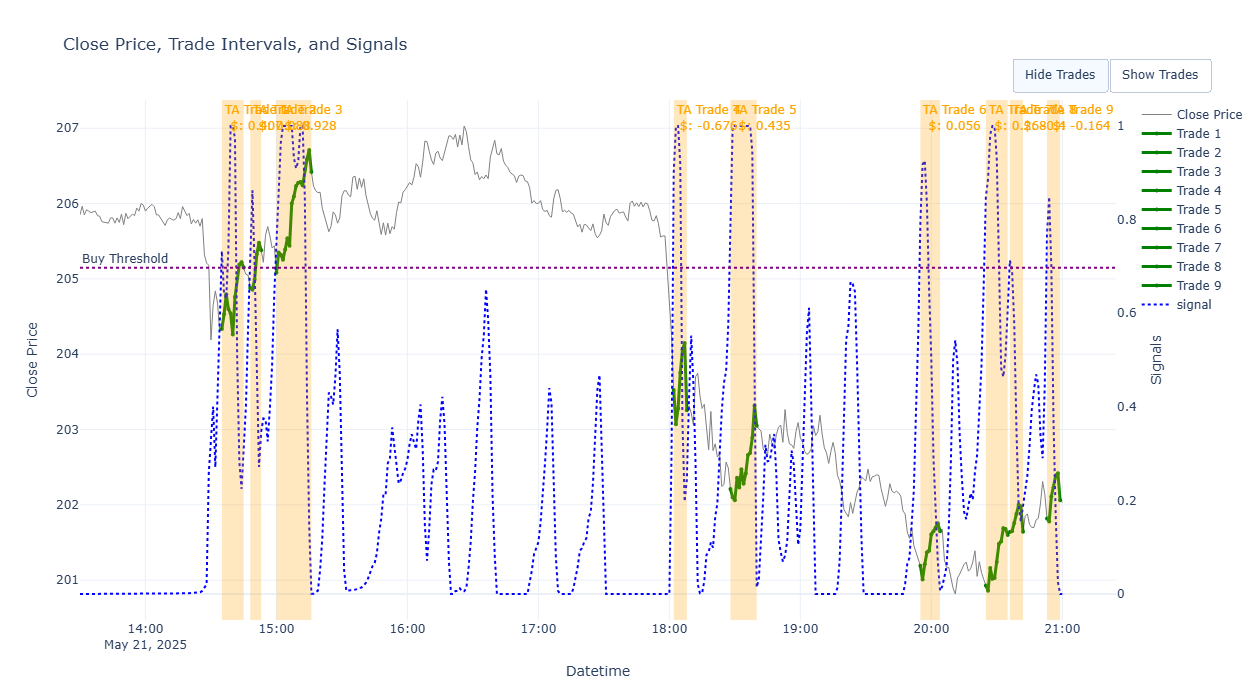


* Performance for 2025-05-21 *
  Buy & Hold Return ($): -2.566
  Strategy Return ($): 0.942
  Trades Returns ($): [0.407, 0.088, 0.928, -0.676, 0.435, 0.056, 0.268, -0.4, -0.164]

=== Processing trading day 2025-05-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


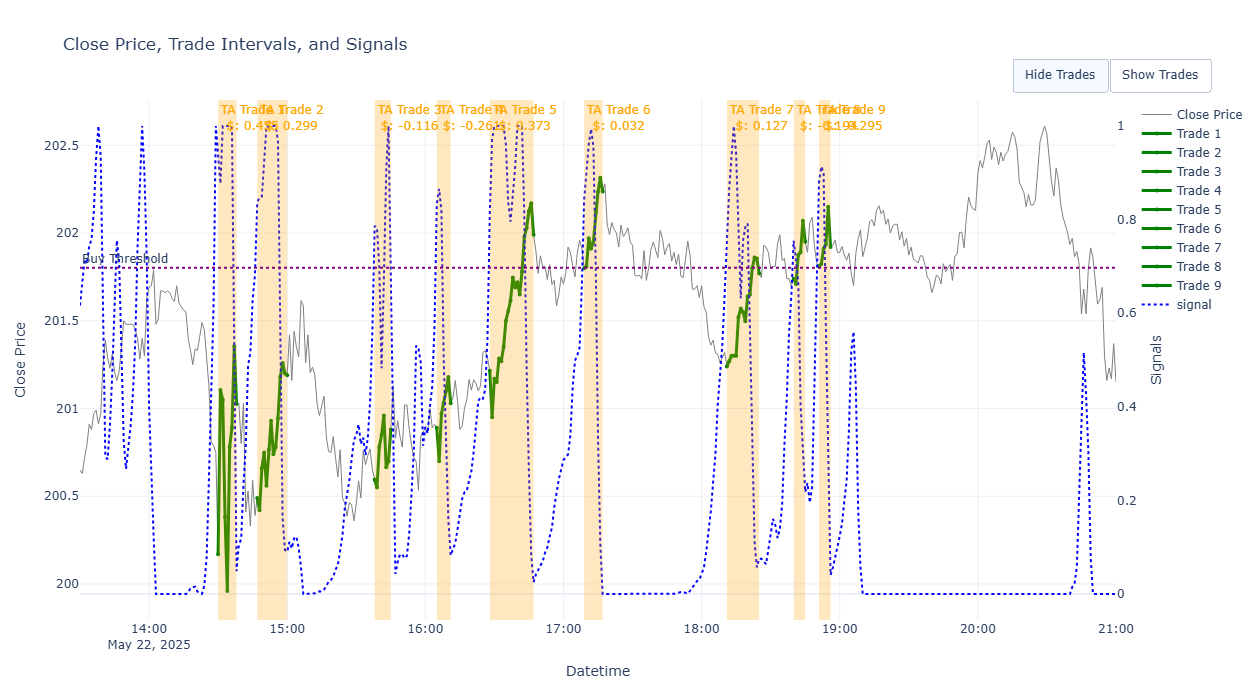


* Performance for 2025-05-22 *
  Buy & Hold Return ($): 0.579
  Strategy Return ($): 0.417
  Trades Returns ($): [0.455, 0.299, -0.116, -0.261, 0.373, 0.032, 0.127, -0.194, -0.295]

=== Processing trading day 2025-05-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


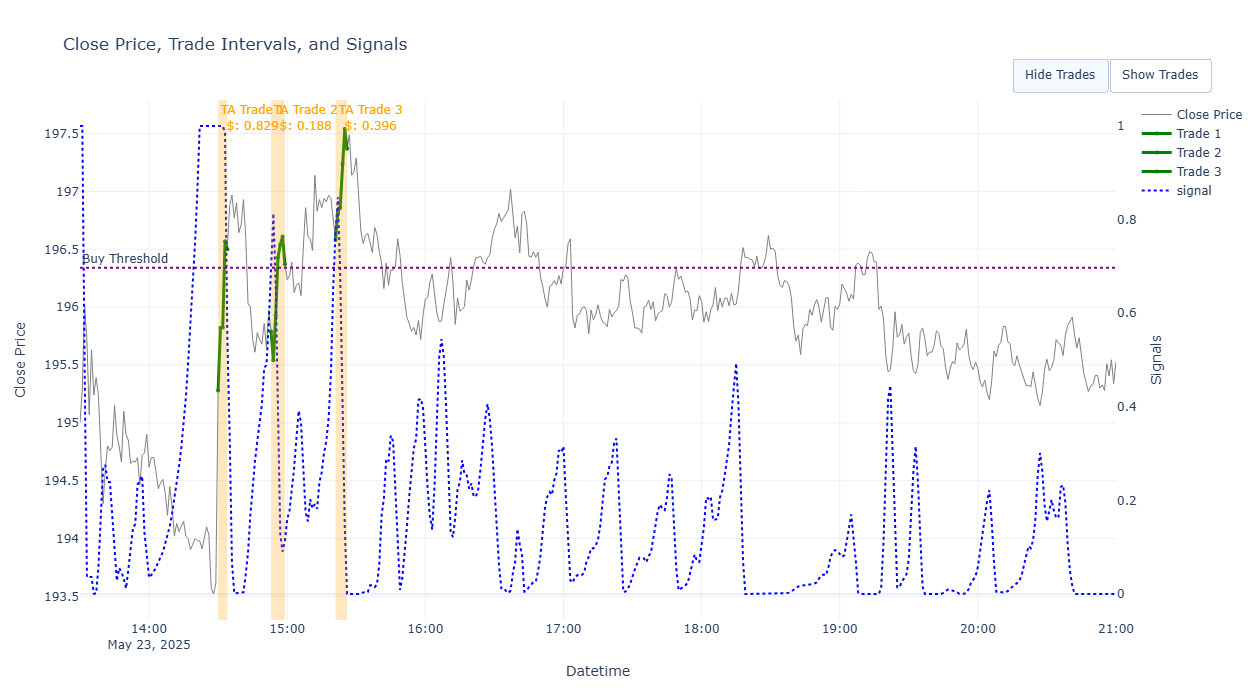


* Performance for 2025-05-23 *
  Buy & Hold Return ($): -0.141
  Strategy Return ($): 1.412
  Trades Returns ($): [0.829, 0.188, 0.396]

=== Processing trading day 2025-05-27 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


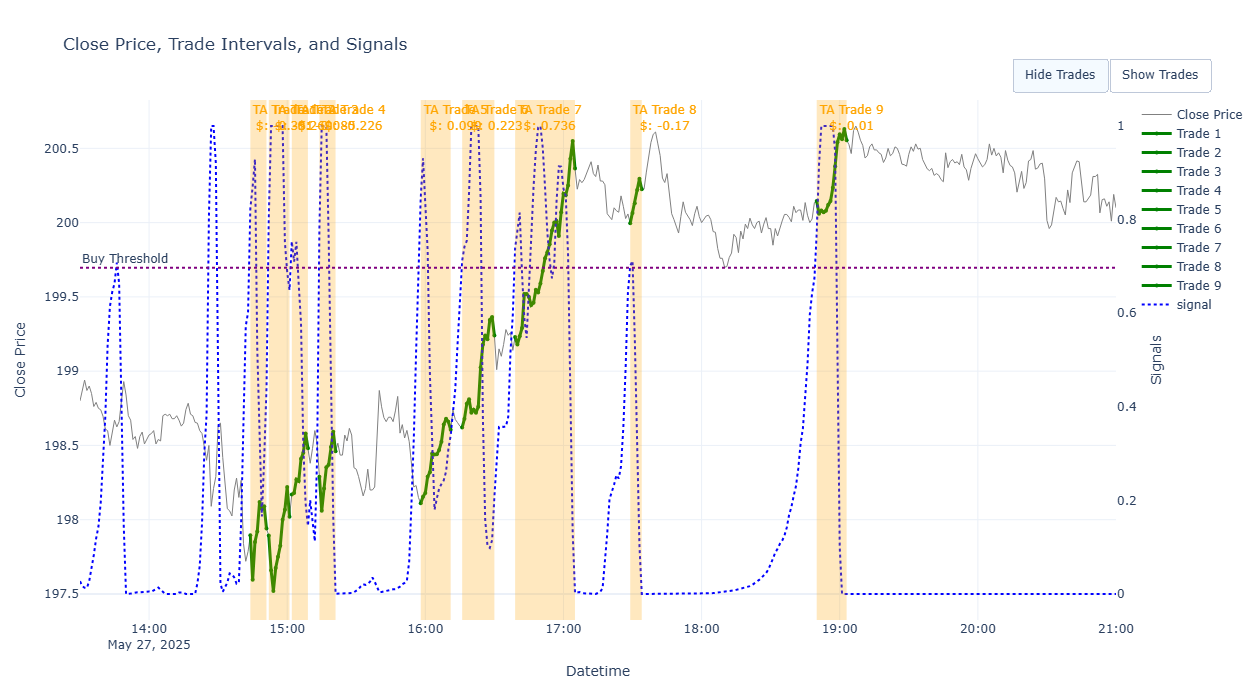


* Performance for 2025-05-27 *
  Buy & Hold Return ($): 1.066
  Strategy Return ($): -0.038
  Trades Returns ($): [-0.351, -0.269, -0.085, -0.226, 0.099, 0.223, 0.736, -0.17, 0.01]

=== Processing trading day 2025-05-28 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


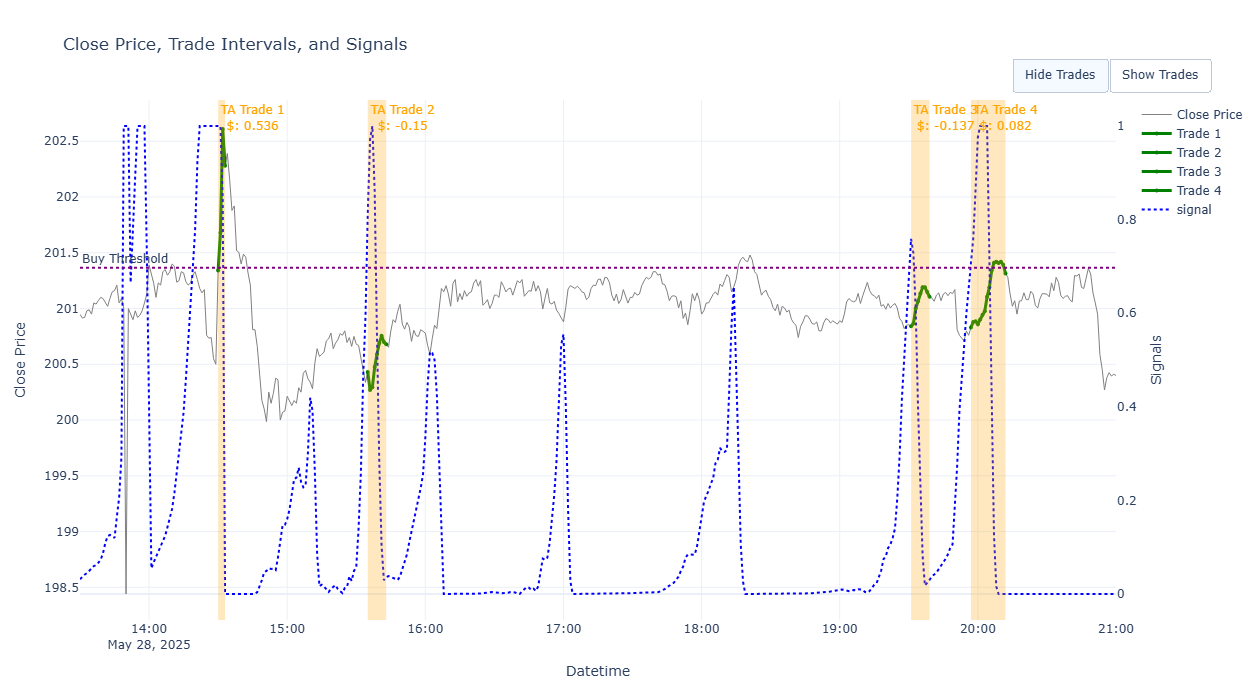


* Performance for 2025-05-28 *
  Buy & Hold Return ($): -1.342
  Strategy Return ($): 0.331
  Trades Returns ($): [0.536, -0.15, -0.137, 0.082]

=== Processing trading day 2025-05-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


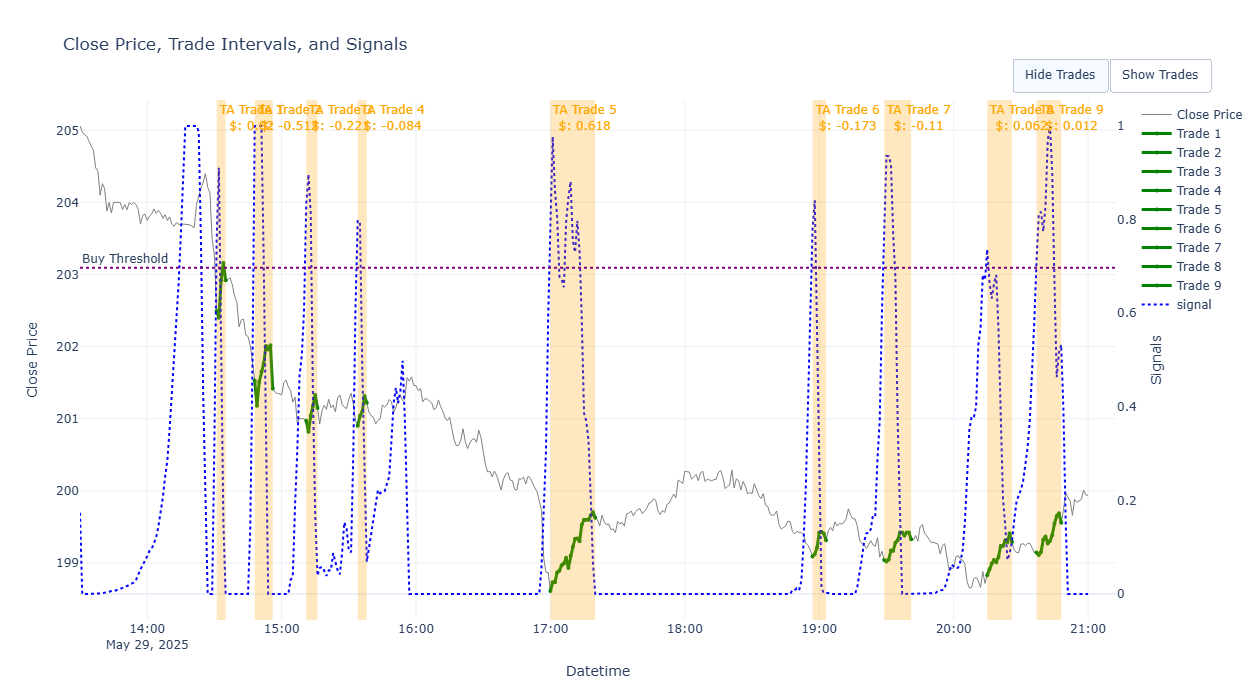


* Performance for 2025-05-29 *
  Buy & Hold Return ($): -3.733
  Strategy Return ($): -0.39
  Trades Returns ($): [0.02, -0.512, -0.221, -0.084, 0.618, -0.173, -0.11, 0.062, 0.012]

=== Processing trading day 2025-05-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


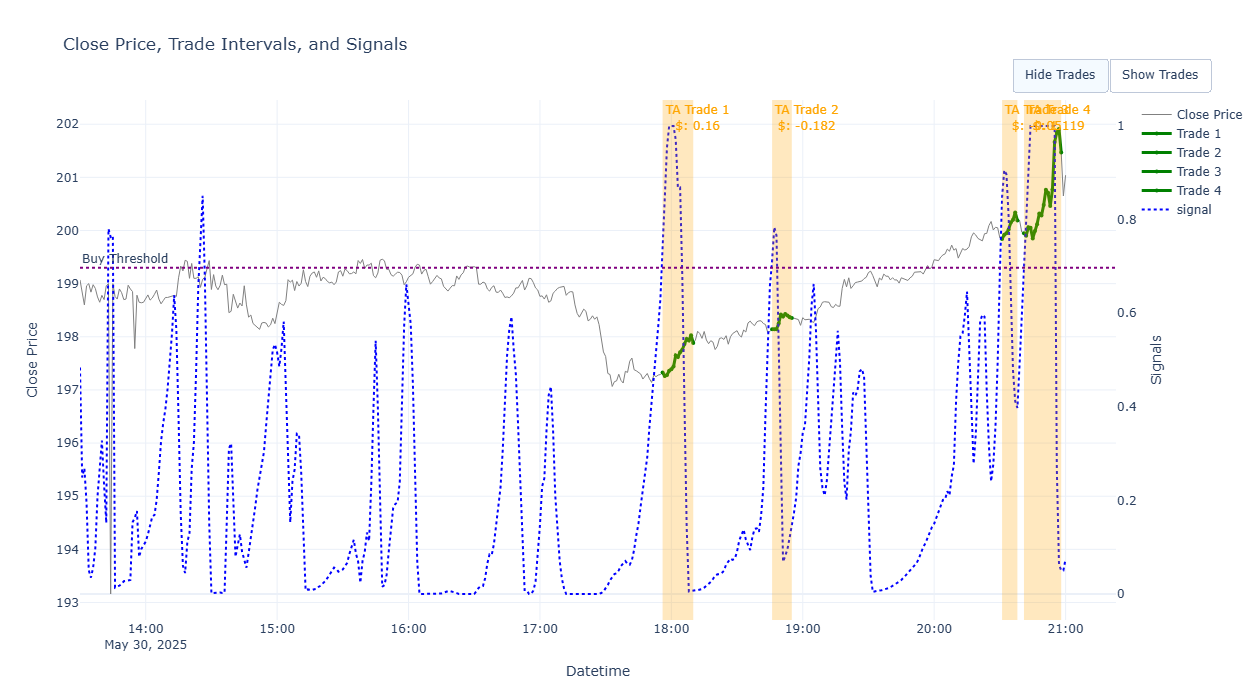


* Performance for 2025-05-30 *
  Buy & Hold Return ($): 1.75
  Strategy Return ($): 1.047
  Trades Returns ($): [0.16, -0.182, -0.05, 1.119]

Overall Summary (2025-05-01 = 210.9207 → 2025-05-30 = 200.8390)

One-time buy&hold gain: -10.082
Buy & Hold – each day ($): -10.131
Strategy Return ($): 20.896
Trades Count: 141
Strategy return per trade: 0.148
Num. trading days: 21
Strategy return per trading day: 0.995


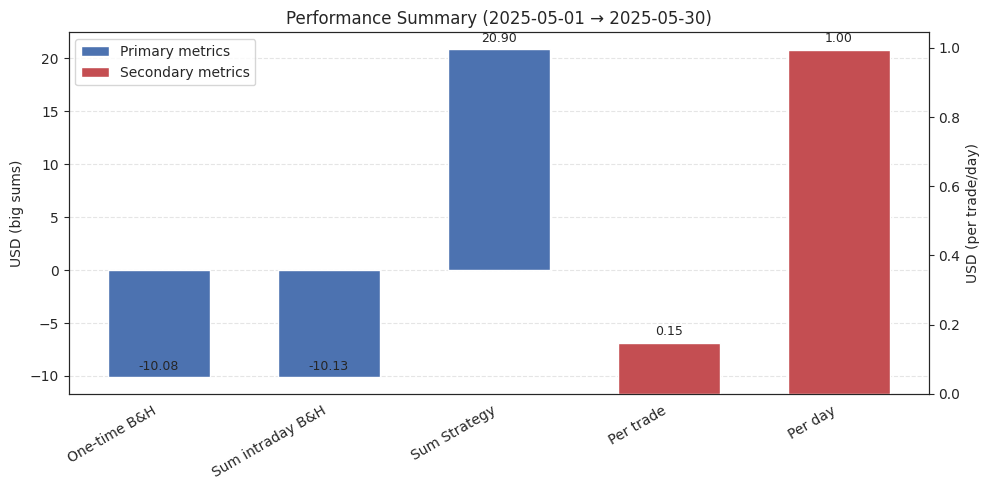

open      high     low    close      volume       ask  \
2025-05-01 12:00:00  210.030  210.0600  209.80  209.860     15609.0  210.0699   
2025-05-01 12:01:00  209.870  210.1100  209.85  210.110      3102.0  210.3201   
2025-05-01 12:02:00  210.100  210.2000  210.07  210.200      1545.0  210.4102   
2025-05-01 12:03:00  210.190  210.2900  210.19  210.270      2311.0  210.4803   
2025-05-01 12:04:00  210.270  210.2800  210.12  210.120      1959.0  210.3301   
...                      ...       ...     ...      ...         ...       ...   
2025-05-30 20:56:00  201.650  201.8700  201.59  201.845    586284.0  202.0468   
2025-05-30 20:57:00  201.840  201.9312  201.82  201.910    724144.0  202.1119   
2025-05-30 20:58:00  201.905  201.9600  201.45  201.470   1021062.0  201.6715   
2025-05-30 20:59:00  201.460  201.4600  200.64  200.650   2535846.0  200.8506   
2025-05-30 21:00:00  200.650  201.1000  200.47  201.040  34101243.0  201.2410   

                          bid    signal  signal_action  Position     Cash  \
2025-05-01 12:00:00  209.6501  0.000189              0         0    0.000   
2025-05-01 12:01:00  209.8999  0.000197              0         0    0.000   
2025-05-01 12:02:00  209.9898  0.000214              0         0    0.000   
2025-05-01 12:03:00  210.0597  0.000247              0         0    0.000   
2025-05-01 12:04:00  209.9099  0.000290              0         0    0.000   
...                       ...       ...            ...       ...      ...   
2025-05-30 20:56:00  201.6432  0.267591              0         1 -200.222   
2025-05-30 20:57:00  201.7081  0.062531              0         1 -200.222   
2025-05-30 20:58:00  201.2685  0.050135             -1         0    1.047   
2025-05-30 20:59:00  200.4494  0.050135              0         0    1.047   
2025-05-30 21:00:00  200.8390  0.075202              0         0    1.047   

                     NetValue    Action  TradedAmount  BuyHoldEarning  \
2025-05-01 12:00:00     0.000  No trade             0           0.000   
2025-05-01 12:01:00     0.000  No trade             0           0.000   
2025-05-01 12:02:00     0.000  No trade             0           0.000   
2025-05-01 12:03:00     0.000  No trade             0           0.000   
2025-05-01 12:04:00     0.000  No trade             0           0.000   
...                       ...       ...           ...             ...   
2025-05-30 20:56:00     1.422      Hold             0           2.554   
2025-05-30 20:57:00     1.486      Hold             0           2.619   
2025-05-30 20:58:00     1.047      Sell            -1           2.180   
2025-05-30 20:59:00     1.047      Hold             0           1.361   
2025-05-30 21:00:00     1.047  No trade             0           1.750   

                     StrategyEarning  EarningDiff  
2025-05-01 12:00:00            0.000        0.000  
2025-05-01 12:01:00            0.000        0.000  
2025-05-01 12:02:00            0.000        0.000  
2025-05-01 12:03:00            0.000        0.000  
2025-05-01 12:04:00            0.000        0.000  
...                              ...          ...  
2025-05-30 20:56:00            1.422       -1.132  
2025-05-30 20:57:00            1.486       -1.133  
2025-05-30 20:58:00            1.047       -1.133  
2025-05-30 20:59:00            1.047       -0.314  
2025-05-30 21:00:00            1.047       -0.703  

[11361 rows x 17 columns]

In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        hyperparams=best_params
                        )

df_fin

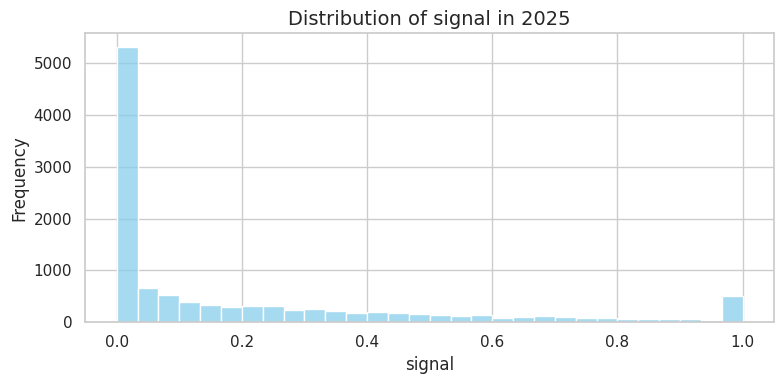

signal_min  signal_max  signal_mean  signal_median  close_return
2025-05         0.0         1.0     0.204584       0.050354      0.109857

In [7]:
pd.set_option('display.max_rows', None)

# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
